# Foundations of Data Mining: Fashion-MNIST Challenge

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
# Please fill in your names here
NAME_STUDENT_1 = "Rashmi Kamath 1281879"

In [6]:
# Changing anything here requires a notebook kernel restart
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100 # Controls the size of your figures
InteractiveShell.ast_node_interactivity = "all" # Show all cell outputs or just the output of the last command

In [7]:
# New imports for Gabor filters. Requires that scikit-image is installed (see below)
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

## Fashion-MNIST
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [8]:
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [9]:
fmnist_data = oml.datasets.get_dataset(40996) # Download MNIST data
# Get the predictors X and the labels y
X, y = fmnist_data.get_data(target=fmnist_data.default_target_attribute); 

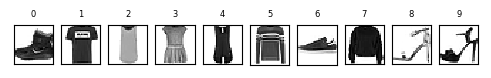

In [10]:
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize=6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X[i])
    titles.append(i)

buildFigureList(plt.figure(1),subfiglist, titles, 10)
plt.show()

## Question 3
In the final part of the assignment, we will use linear models and RandomForests to build classification models, also using a particular new representation of the data using _Gabor filters_.

### Installation notes
We'll be using an existing Gabor filter implementation available in scikit-image, a library that implements lots of useful techniques for image processing.

scikit-image can be easily installed in your current conda installation via
`conda install scikit-image`

Or see the installation instructions if you have a different setup: http://scikit-image.org/docs/dev/install.html 

### Gabor filters
A Gabor filter is a linear filter defined as an harmonic/sinusoidal function multiplied by a Gaussian
function. They are often used as edge, line, and shape detectors in continuous data such as images or sound, and there is quite some literature suggesting that our brains do a similar kind of processing. In this assignment, we'll use them to build new features for our image classification problem. Indeed, images usually have a lot of infromation in them that is not directly needed to do the classification, and we can simplify the task if we can construct features that contain only the most relevant information (e.g., where the object's edges are).

Hence, we will be replacing the orginal image with an image that only contains the edges of the object. This is done by first creating a `convolution kernel` (or _mask_), a small 2D array of pixels. Then, the kernel is moved over every pixel of the input image and performing a _convolution_, basically replacing every pixel value with the sum of all surrounding pixels, weighted elementwise by the values of the kernel. For instance, if the kernel would be a simple Gaussian, the nearby pixels would be weighted a lot more than those further away. For more information, see this short tutorial: https://cvtuts.wordpress.com/2014/04/27/gabor-filters-a-practical-overview/

_Note: in this tutorial they explore the wavelength $lambda$. In our scikit-learn implementation we'll be changing the inverse of the wavelength $f=\frac{1}{\lambda}$, i.e. the frequency._

We'll show some examples to get you started,

### Gabor kernels
In the interactive demo below, first set frequency=0.1, theta=0, sigma=5. You should now see a wave-like pattern: high in the middle, oscillation along the x-axis, dampening along the y-axis. This is created by multiplying a sinusoidal wave with a Gaussian that dampens all values in all directions. You can also see this in 3D here: http://www.di.uniba.it/~ig/GaborFilter/html/filtro.html

The demo allows you to change 3 important parameters:
- **Frequency** of the sinusoidal component, specified in pixels. For a fixed sigma (see below), increasing frequency will build kernels with more oscillations. Note: If no sigma value is provided, frequency will also affect the kernel width (in pixels).
- **Theta**: the orientation (rotation) of the sinusoidal component, in radians. A value of 0 means that the wave oscillates along the x-direction, a value of $\frac{\pi}{2}=1,57$ oscillates along the y-direction.
- **Sigma**: standard deviation of the Gaussian component. Larger values mean a slower decay of the values and create a wider kernel (more pixels). It's possible to add different sigma values for the x- and y-direction.

Further details about the Gabor filter implementation are available here:
http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gabor

In [11]:
# Gabor Filters.
# For illustration purposes, can be removed for the submission
from IPython.html.widgets import interact, interactive, fixed
def demoGabor(frequency, theta, sigma):
    plt.gray()
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
interact(demoGabor, theta=(0,3.14,0.1), frequency=(0.01,1,0.05), sigma=(0,5,0.1));

C:\Users\Rashmi\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=0.46, description='frequency', max=1.0, min=0.01, step=0.05), FloatSlider(value=1.5, description='theta', max=3.14), FloatSlider(value=2.0, description='sigma', max=5.0), Output()), _dom_classes=('widget-interact',))

### Applying Gabor filters
As mentioned above, applying Gabor filters means doing a convolution of the Gabor kernel with the original image. For practical reasons, we are mainly interested in the _magnitude_ of the output, which smooths out the original (sinusoidal and phase sensitive) responses. This is done by computing the square root of the sum of squared real and imaginary outputs. We provide a little helper function for you:

In [12]:
# Don't edit this cell
# Calculates the magnitude of the Gabor filter response given a kernel and an imput image
def magnitude(image, kernel):
    image = (image - image.mean()) / image.std() # Normalize images
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

In [13]:
# For illustration purposes, can be removed for the submission
# Fetch some Fashion-MNIST images and reshape to 28x28 matrix
boot = X[0].reshape(28, 28)
shirt = X[1].reshape(28, 28)
dress = X[2].reshape(28, 28)
image_names = ('boot', 'shirt', 'dress')
images = (boot, shirt, dress)

In [14]:
# For illustration purposes, can be removed for the submission
# Gabor filters applied to Fashion-MNIST example
# Note: it may take a second to do the convolution after you change settings
def demoGabor(frequency, theta, sigma):
    plt.subplot(121)
    plt.title('Gabor kernel')
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
    plt.subplot(122)
    plt.title('Response magnitude')
    plt.imshow(np.real(magnitude(boot, gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))), interpolation='nearest')
interact(demoGabor, theta=(0,3.14,0.1), frequency=(0.01,1,0.05), sigma=(0,5,0.1));

interactive(children=(FloatSlider(value=0.46, description='frequency', max=1.0, min=0.01, step=0.05), FloatSlider(value=1.5, description='theta', max=3.14), FloatSlider(value=2.0, description='sigma', max=5.0), Output()), _dom_classes=('widget-interact',))

We can now show the response of several Gabor filters on the Fashion-MNIST images.

The first 4 images show the effect of sigma and frequency:
- Smaller sigma's detect smaller edges
- Higher frequencies blur the response (make edges less location-specific)

The first 4 images show the effect of theta:
- Theta defines in which direction the filter detects images (here: 45 degree-angled edges)
- Again, higher frequencies blur the response (make edges less location-specific)

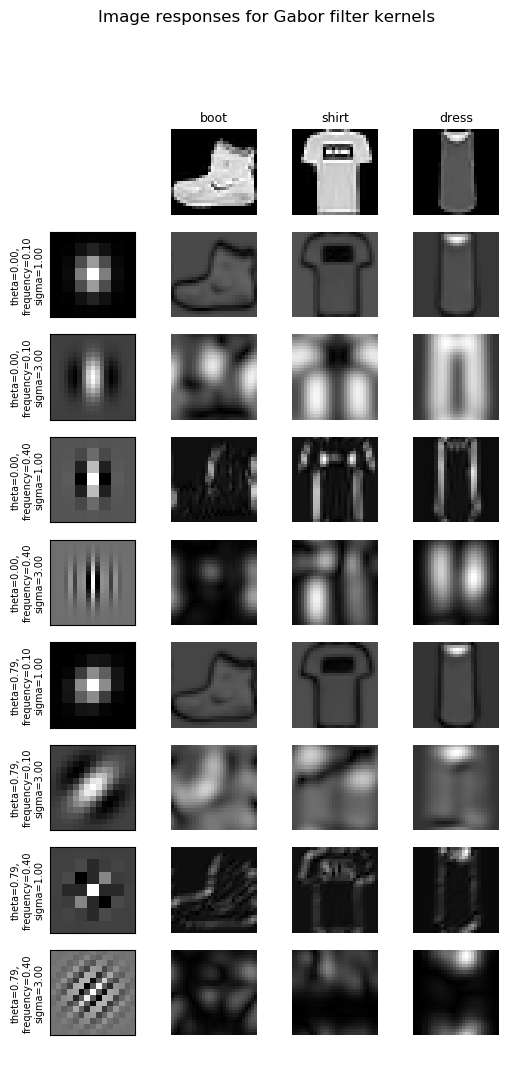

In [15]:
# For illustration purposes, can be removed for the submission
# Create a set of kernels, apply them to each image, store the results
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        for sigma in (1, 3):
            kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma,sigma_y=sigma)
            params = 'theta=%.2f,\nfrequency=%.2f\nsigma=%.2f' % (theta, frequency, sigma)
            kernel_params.append(params)
            results.append((kernel, [magnitude(img, kernel) for img in images]))

# Plotting
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(6, 12))
plt.gray()
fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, magnitudes), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([]) # Remove axis ticks 
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(magnitudes)
    vmax = np.max(magnitudes)
    for patch, ax in zip(magnitudes, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax) # Plot convolutions
        ax.axis('off')

plt.show();

### Constructing features
Now we can use the Gabor filter to build new features for classifying fashion items.

A specific collection of Gabor filters is called a _Gabor filter bank_ or _Gabor family_. Here, we visualize a specific filter bank and the response on a specific image. We can only show 2D, so we fix sigma, but feel free to adapt the code to view the effect of varying sigma instead. 

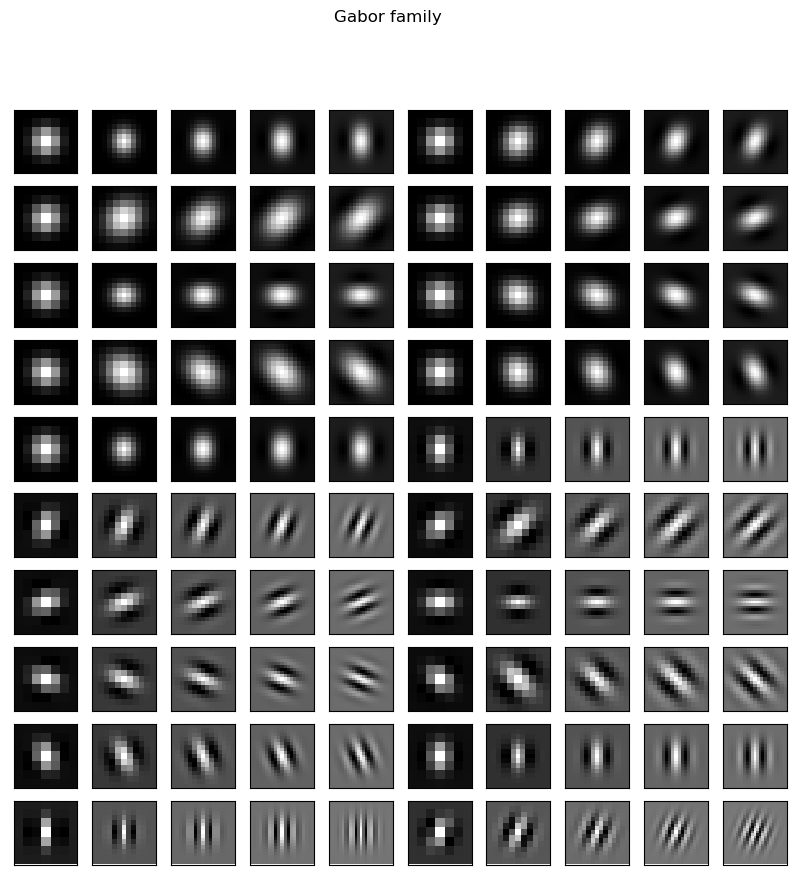

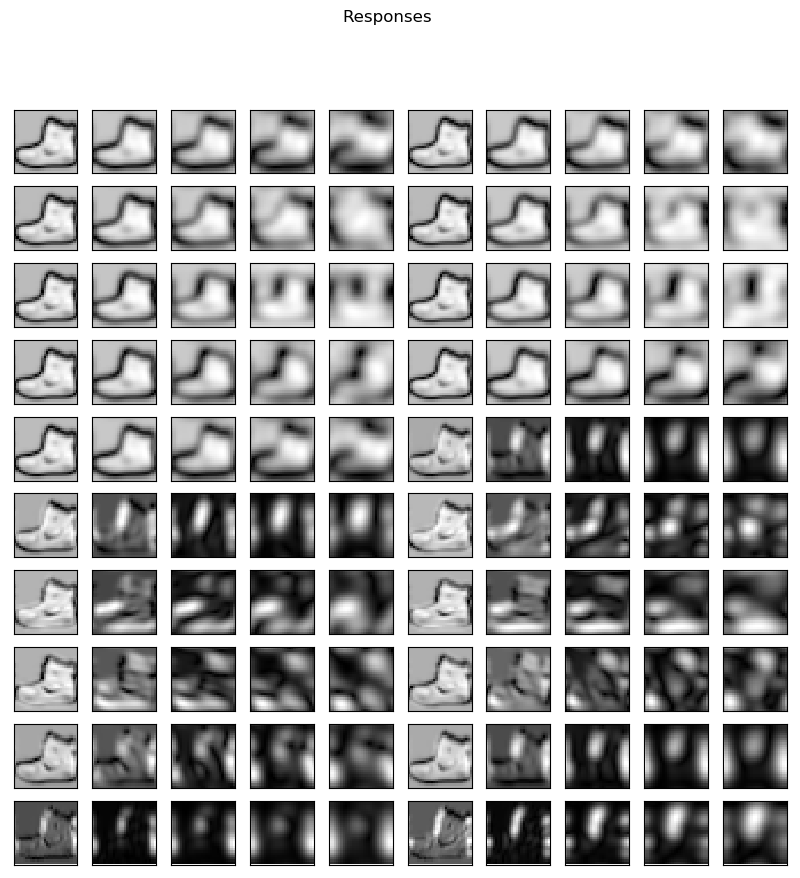

In [16]:
# For illustration purposes, can be removed for the submission
# Fetch some Fashion-MNIST images
# Create a set of kernels, apply them to each image, store the results
img = boot
kernels = []
results = []
for frequency in np.linspace(0.05,0.5,5): # 5 values for n_stds
    for theta in np.linspace(0,3.14,9): # 5 values for theta
        for sigma in np.linspace(1,4,5): # 5 values for sigma
            kernel = gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
            kernels.append(kernel)
            results.append(magnitude(img, kernel))

# Plotting Gabor family
fig, axes = plt.subplots(ncols=10, nrows=10, figsize=(10, 10))
plt.gray()
fig.suptitle('Gabor family', fontsize=12)

for kernel, ax in zip(kernels, axes.flatten()):
    # Plot Gabor kernel
    ax.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
    ax.set_xticks([]) # Remove axis ticks 
    ax.set_yticks([])
    
plt.show();

# Plotting Responses
fig, axes = plt.subplots(ncols=10, nrows=10, figsize=(10, 10))
plt.gray()
fig.suptitle('Responses', fontsize=12)

for response, ax in zip(results, axes.flatten()):
    # Plot Gabor kernel
    vmin = np.min(response)
    vmax = np.max(response)
    ax.imshow(np.real(response), vmin=vmin, vmax=vmax) # Plot magnitudes
    ax.set_xticks([]) # Remove axis ticks 
    ax.set_yticks([])

plt.show();

To construct a feature vector, we need to aggregate the results. One common way to do this is to simply compute the mean and standard deviation.

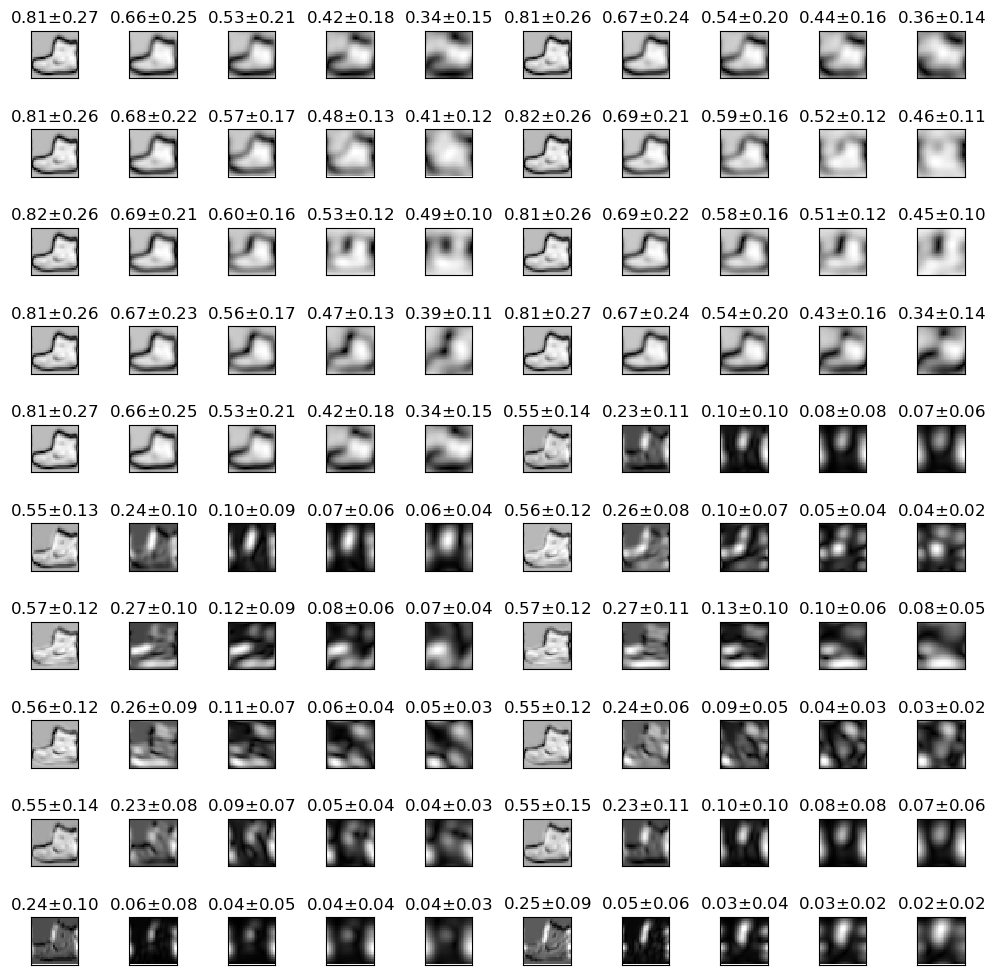

In [17]:
# For illustration purposes, can be removed for the submission
# Plotting Responses plus aggregate values
fig, axes = plt.subplots(ncols=10, nrows=10, figsize=(10, 10))
plt.gray()
fig.tight_layout()

for response, ax in zip(results, axes.flatten()):
    # Plot Gabor kernel
    vmin = np.min(response)
    vmax = np.max(response)
    ax.imshow(np.real(response), vmin=vmin, vmax=vmax) # Plot magnitudes
    ax.set_title("{:.2f}$\pm${:.2f}".format(np.mean(response),np.std(response)))
    ax.set_xticks([]) # Remove axis ticks 
    ax.set_yticks([])

plt.show();

In [18]:
# Don't edit this cell
# Builds a feature vector given an input image and a Gabor filter bank (kernels)
def gabor_features(image, kernels):
    feats = np.zeros(len(kernels))
    for k, kernel in enumerate(kernels):
        filtered = magnitude(image, kernel)
        feats[k] = filtered.mean()
    return feats

# Variation that computes both the mean and standard deviation
def gabor_features_double(image, kernels):
    feats = np.zeros(len(kernels)*2)
    for k, kernel in enumerate(kernels):
        filtered = magnitude(image, kernel)
        feats[k*2] = filtered.mean()
        feats[k*2+1] = filtered.std()
    return feats

In [19]:
gabor_features(boot, kernels)

array([0.81 , 0.663, 0.528, 0.417, 0.336, 0.812, 0.67 , 0.544, 0.441,
       0.364, 0.814, 0.678, 0.57 , 0.48 , 0.412, 0.815, 0.691, 0.593,
       0.521, 0.464, 0.815, 0.693, 0.599, 0.533, 0.485, 0.814, 0.686,
       0.585, 0.511, 0.453, 0.812, 0.672, 0.559, 0.465, 0.392, 0.81 ,
       0.665, 0.536, 0.428, 0.343, 0.81 , 0.663, 0.528, 0.417, 0.336,
       0.546, 0.229, 0.101, 0.078, 0.069, 0.553, 0.239, 0.102, 0.071,
       0.059, 0.563, 0.258, 0.102, 0.055, 0.038, 0.569, 0.27 , 0.123,
       0.081, 0.069, 0.568, 0.273, 0.132, 0.095, 0.081, 0.562, 0.258,
       0.111, 0.063, 0.046, 0.553, 0.241, 0.088, 0.04 , 0.028, 0.546,
       0.226, 0.087, 0.051, 0.04 , 0.546, 0.229, 0.101, 0.078, 0.069,
       0.241, 0.056, 0.044, 0.04 , 0.036, 0.247, 0.05 , 0.033, 0.027,
       0.023, 0.255, 0.046, 0.028, 0.023, 0.021, 0.263, 0.063, 0.04 ,
       0.03 , 0.024, 0.264, 0.076, 0.059, 0.05 , 0.044, 0.256, 0.057,
       0.037, 0.028, 0.022, 0.246, 0.041, 0.024, 0.02 , 0.017, 0.241,
       0.045, 0.028,

## Tasks

0. Take a 10% stratified subsample of the FashionMNIST data. On this subsample, do a default stratified train-test split (holdout).
1. Run logistic regression and report training time and accuracy on your train-test split. Tune the C hyperparameter in the range $10^{-6} ... 10^{1}$ on a log scale.
2. Run a RandomForest classifier and report training time and accuracy. Do a small grid search tuning the 'n_estimators' [10,100] and 'max_depth' [10,50].
3. Construct a new dataset using the Gabor filter bank as described above (using the given filter bank and only computing the mean). Run the linear and RandomForest classifier (default settings) and see if these features yield better performance. 
    - Note: computing the Gabor features may take a while (over an hour). If you are under time constraints, take a smaller (stratified) subsample of the FashionMNIST data, or use a smaller filter bank.
4. Open question: try to improve performance by
    - Constructing a different set of Gabor features (can be smaller or larger) 
    - Training different classifiers (or simple pipelines) on the constructed features. Consider which classifiers can be trained efficiently on your dataset.
    
Your answer on the last question is evaluated based on the soundness of your reasoning (even if you don't find a better model).

#### 1. Take 10% stratified subsample of the FashionMNIST data. On this subsample, do a default stratified train-test split (holdout).
#### 2. Run logistic regression and report training time and accuracy on your train-test split.

In [42]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from random import randint
import time 

#Train test split on 10% stratified subsample 
X_10, X_90, y_10, y_90 = train_test_split(X, y, train_size=0.1, stratify=y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_10, y_10, stratify=y_10, random_state=0)
temp_time= time.time()

# logistic regression, training time and accuracy
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
train_time= time.time()-temp_time 

print("Training time in sec: {:.4f}". format(train_time))
print("Test score: {:.4f}".format(logreg.score(X_test, y_test)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training time in sec: 145.5713
Test score: 0.7474


#### 2.  Tune the C hyperparameter in the range $10^{-6} ... 10^{1}$ on a log scale.

In [39]:
param_grid = {'C': np.logspace(-6,1,8,base=2)
              }
grid_search = GridSearchCV(logreg, param_grid);
grid_search.fit(X_train, y_train);

In [36]:
#Reporting best score 
print("Best score is {:.4f} at C = {:.4f}".format(grid_search.best_score_,grid_search.best_params_["C"]))

Best score is 0.7634 at C = 0.0156


#### 3. Run a RandomForest classifier and report training time and accuracy. Do a small grid search tuning the 'n_estimators' [10,100] and 'max_depth' [10,50].

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# reporting training time 
temp_time1= time.time()
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

train_time1= time.time()-temp_time1 
print("Training time in sec: {:.4f}". format(train_time1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training time in sec: 0.9219


In [60]:
param_dist = {"max_depth": [10,20,30,40,50],
              "n_estimators" : [10,20,30,40,50,60,70,80,90,100]}
grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_dist, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train);

#Reporting accuracy
print('Best configuration:', grid_search.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best configuration: {'max_depth': 30, 'n_estimators': 100}


With below heatmap we can see that 'max_depth': 30, 'n_estimators': 100 gives the best configuration of 0.85

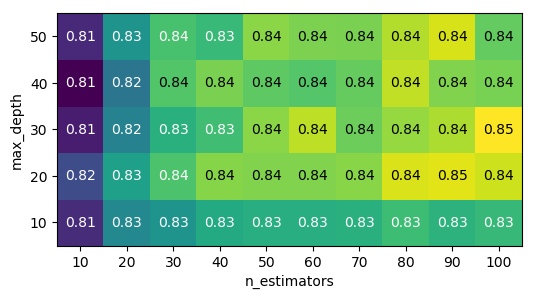

In [61]:
# Plotting the heatmap for max_depth and n_estimators 

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(5,10)
mglearn.tools.heatmap(scores, xlabel='n_estimators', xticklabels=param_dist['n_estimators'],
                      ylabel='max_depth', yticklabels=param_dist['max_depth'], cmap="viridis");

#### 4. Construct a new dataset using the Gabor filter bank as described above (using the given filter bank and only computing the mean). Run the linear and RandomForest classifier (default settings) and see if these features yield better performance. 
    (I tried to take 10% stratified subsample but it was running for longer than 2 and half hours so interrupted and took 1%)

I took only 1% stratified subsample still I get score of 0.6(Random forest) and 0.58(Logistic) using gabor filter, I can therefore conclude that 10% stratified subsample which I used for the above question would have definately given much better accuracy with gabor filter than without the gabor filter. 
- Conclusion: Gabor filter features yield better performance however, it takes lot of time to apply and run. 

In [74]:
#Train test split(75-25) on 1% stratified subsample 
X_1, X_99, y_1, y_99 = train_test_split(X, y, train_size=0.01, stratify=y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, stratify=y_1, random_state=0)

In [65]:
#Applying gabor filter bank on the 1% stratified subsample using method "gabor_features" above
g_train = []
g_test = [] 

for i in X_train: 
    gf=gabor_features(i.reshape(28,28),kernels)
    g_train.append(gf)

for i in X_test: 
    gf=gabor_features(i.reshape(28,28),kernels)
    g_test.append(gf)
    
g_train = np.array(g_train)
g_test= np.array(g_test)

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Random forest classifier with default settings
clf = RandomForestClassifier()
clf.fit(g_train,y_train)
print("Test score: {:.4f}".format(clf.score(g_test, y_test)))

# Logistic regression with default settings
logreg = LogisticRegression()
logreg.fit(g_train, y_train) 
print("Test score: {:.4f}".format(logreg.score(g_test, y_test)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Test score: 0.6000


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Test score: 0.5886


#### 5. Open question: try to improve performance by
    - Constructing a different set of Gabor features (can be smaller or larger) 
    - Training different classifiers (or simple pipelines) on the constructed features. Consider which classifiers can be trained efficiently on your dataset.

I tried to analyse the various parameters in Gabor filters for example: 

- Sigma: Is the standard deviation of gaussian function, smaller sigma leads to smaller edges of filter. 
- Theta: Is the orientation, for example 0 theta means horizontal and as you go from 0 to 180 it gets vertical. 
- lambda: is the wavelength 
- gamma: controls the ellipticity, gamma '1' value is the most circular filter. 

I did Theoritical analysis and its effects on the filter however implementation was left out due to lack of time. 